<a href="https://colab.research.google.com/github/RaniaSaeed01/IE423-Tasks/blob/main/IE423_Task10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
from datetime import datetime, timedelta

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/continuous dataset.csv')

In [14]:
df.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [15]:
df.shape

(48048, 17)

In [7]:
df.isnull().sum()

datetime      0
nat_demand    0
T2M_toc       0
QV2M_toc      0
TQL_toc       0
W2M_toc       0
T2M_san       0
QV2M_san      0
TQL_san       0
W2M_san       0
T2M_dav       0
QV2M_dav      0
TQL_dav       0
W2M_dav       0
Holiday_ID    0
holiday       0
school        0
dtype: int64

In [28]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)


In [30]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['week_of_year'] = df.index.isocalendar().week

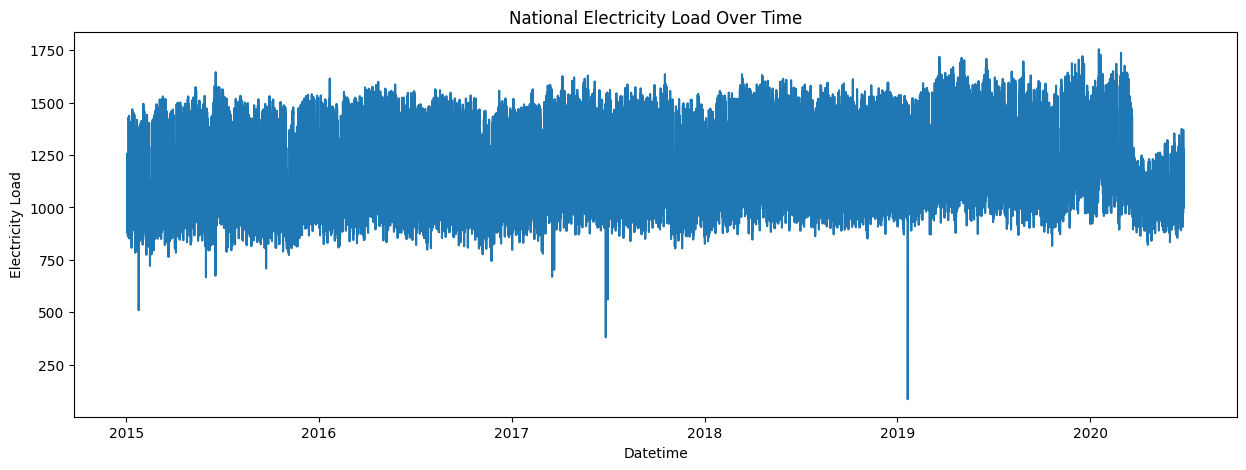

nat_demand      1.000000
T2M_toc         0.652811
T2M_dav         0.648279
T2M_san         0.627024
hour            0.453087
W2M_san         0.191796
year            0.150804
TQL_san         0.119038
W2M_toc         0.098435
TQL_toc         0.073109
TQL_dav         0.042037
school          0.040044
QV2M_san        0.022172
day             0.020161
month           0.006412
week_of_year    0.004966
QV2M_dav       -0.002117
QV2M_toc       -0.036706
W2M_dav        -0.054802
Holiday_ID     -0.129834
holiday        -0.165673
day_of_week    -0.226683
Name: nat_demand, dtype: float64


In [31]:
# Plot the national electricity load
plt.figure(figsize=(15, 5))
plt.plot(df['nat_demand'])
plt.title('National Electricity Load Over Time')
plt.xlabel('Datetime')
plt.ylabel('Electricity Load')
plt.show()

# Check correlations
correlation_matrix = df.corr()
print(correlation_matrix['nat_demand'].sort_values(ascending=False))

Text(0.5, 1.0, 'ACF Plot with Marked Peak at x=24 hours')

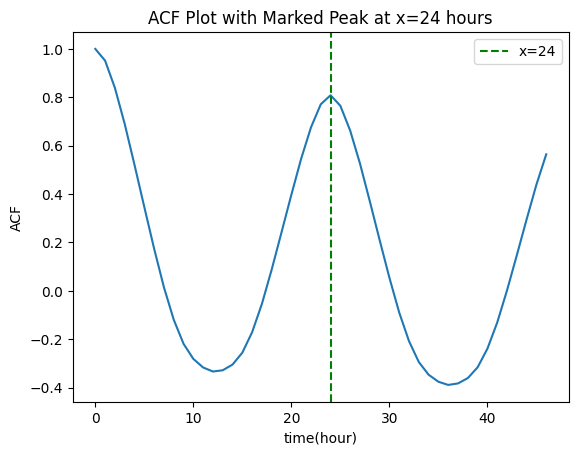

In [39]:
plt.plot(acf(df['nat_demand']))
plt.xlabel('time(hour)')
plt.ylabel('ACF')
plt.axvline(x=24, color='green', linestyle='--', label='x=24')

plt.legend()
plt.title('ACF Plot with Marked Peak at x=24 hours')

Text(0, 0.5, 'Wind Speed at 2 Meters')

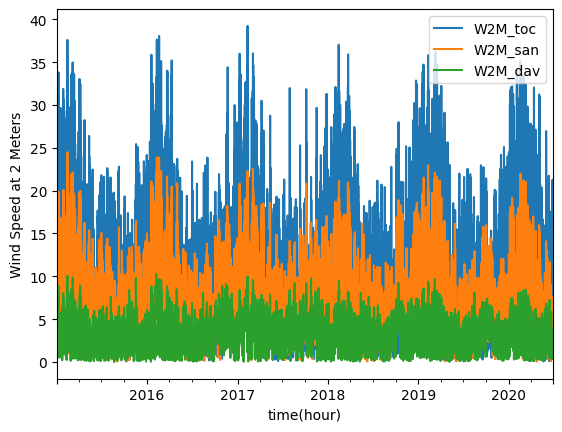

In [45]:
df[['W2M_toc', 'W2M_san','W2M_dav']]['2015-01-03' : '2020-06-27'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Wind Speed at 2 Meters')

Text(0, 0.5, 'Temperature at 2 Meters')

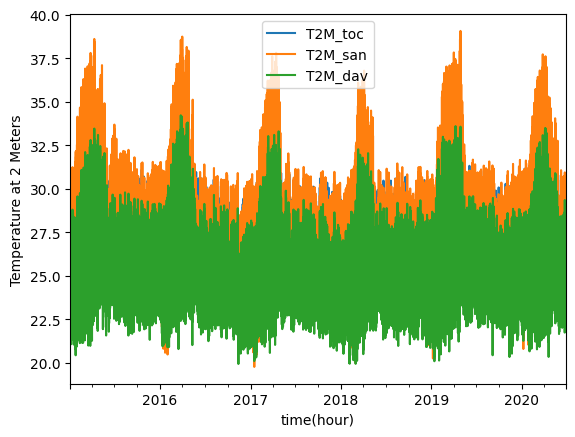

In [42]:
df[['T2M_toc', 'T2M_san','T2M_dav']]['2015-01-03' : '2020-06-27'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Temperature at 2 Meters')

Text(0, 0.5, 'Relative Humidity at 2 Meters')

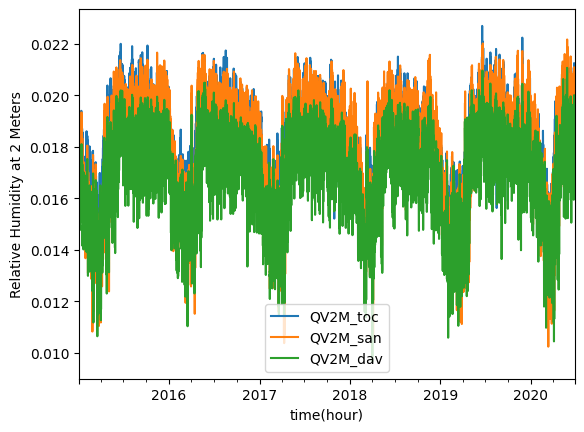

In [43]:
df[['QV2M_toc', 'QV2M_san','QV2M_dav']]['2015-01-03' : '2020-06-27'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Relative Humidity at 2 Meters')

Text(0, 0.5, 'Liquid Precipitation')

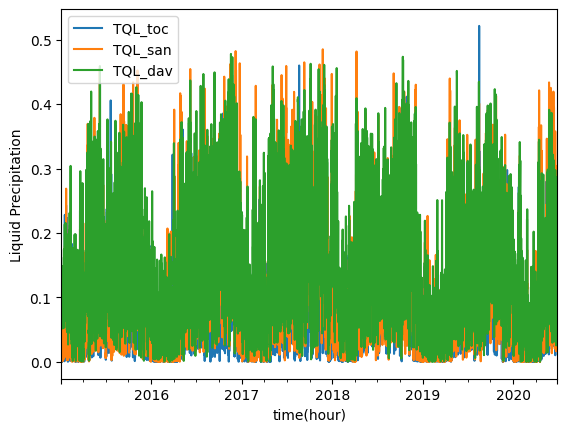

In [44]:
df[['TQL_toc', 'TQL_san','TQL_dav']]['2015-01-03' : '2020-06-27'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Liquid Precipitation')

In [48]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [49]:
adf_test(df['nat_demand'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -20.961750
p-value                     0.000000
# lags used                57.000000
# observations          47990.000000
critical value (1%)        -3.430486
critical value (5%)        -2.861600
critical value (10%)       -2.566802
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [50]:
# Printing the maximum timestamp in the dataset
print(df.index.max())

# Printing the minimum timestamp in the dataset
print(df.index.min())

2020-06-27 00:00:00
2015-01-03 01:00:00


In [52]:
dev_date_str = '2019-01-12'
# Convert dev_date_str to a datetime object
dev_date = datetime.strptime(dev_date_str, '%Y-%m-%d')
# dev_date = pd.Timestamp(dev_date, tz='UTC') # Removing this line to keep dev_date timezone-naive
train_data = df[:dev_date]
test_data = df[dev_date:]

In [56]:
fitted_model = ExponentialSmoothing(train_data['nat_demand'],
                                    trend='add',
                                    seasonal='add',
                                    seasonal_periods=24).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [57]:
# Set the number of days for which the prediction is to be made
number_of_days = 120

# Calculate the total number of hours to predict based on the number of days
number_of_hours_to_predict = number_of_days * 24

# Calculate the end date for the prediction by adding the total hours to the development date (dev_date)
end_date = dev_date + timedelta(hours=number_of_hours_to_predict - 1)

# Extract the actual Gross Consumption data from the test dataset for the specified period
y = test_data['nat_demand'][dev_date:end_date]

# Use the fitted model to forecast the values for the specified number of hours and rename the output series to 'HW_Forecast'
test_predictions = fitted_model.forecast(number_of_hours_to_predict).rename('HW_Forecast')


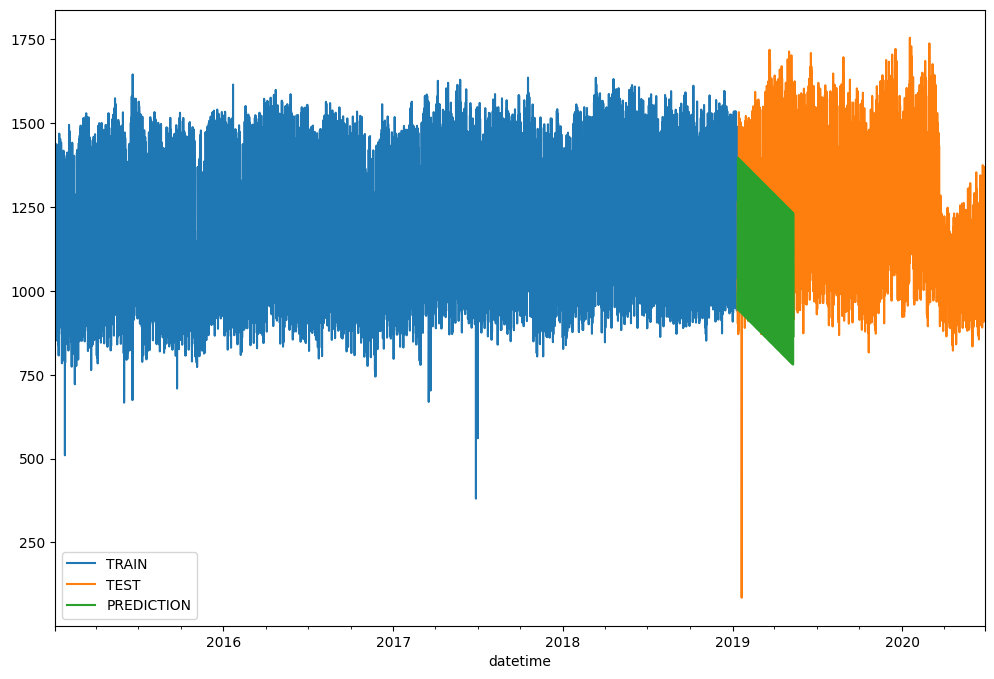

In [58]:
# Plotting the Gross Consumption from the training data
train_data['nat_demand'].plot(legend=True, label='TRAIN')

# Plotting the Gross Consumption from the test data
test_data['nat_demand'].plot(legend=True, label='TEST', figsize=(12,8))

# Plotting the predicted Gross Consumption values
test_predictions.plot(legend=True, label='PREDICTION');

<Axes: xlabel='datetime'>

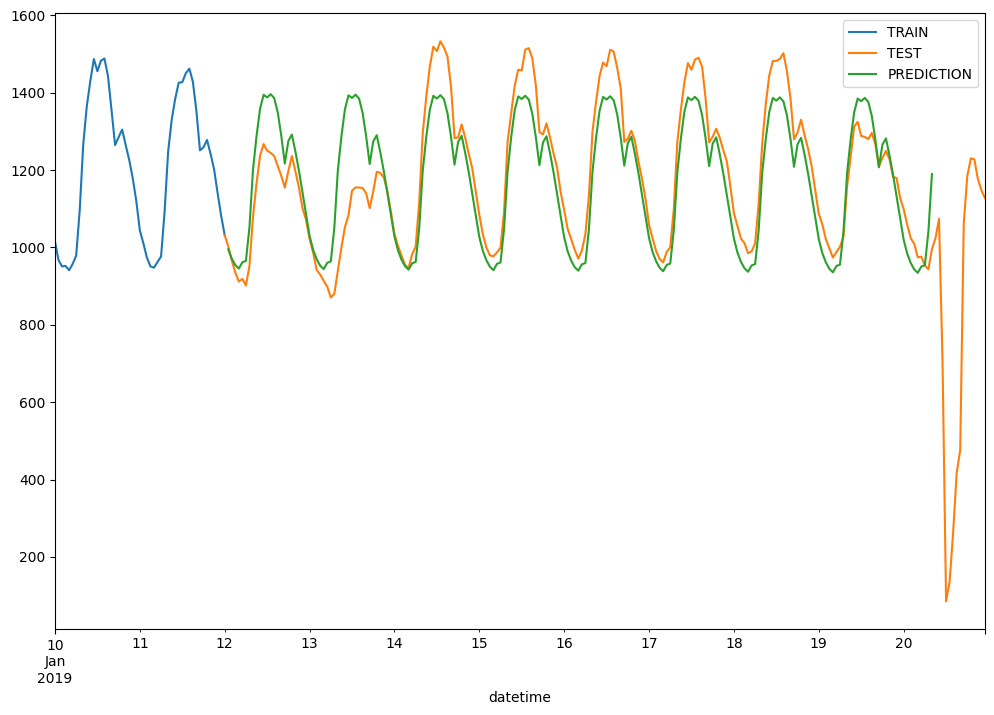

In [61]:
# Plotting the training data
train_data['nat_demand']['2019-01-10':].plot(legend=True, label='TRAIN')

# Plotting the testing data
test_data['nat_demand'][:'2019-01-20'].plot(legend=True, label='TEST', figsize=(12, 8))

# Plotting the predictions (first 200 points)
test_predictions[:200].plot(legend=True, label='PREDICTION')

In [62]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, test_predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 46135.060438586625


In [63]:
import numpy as np
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 214.7907363891344


In [65]:
final_model = ExponentialSmoothing(df['nat_demand'],
                                    trend='add',
                                    seasonal='add',
                                    seasonal_periods=24).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='datetime'>

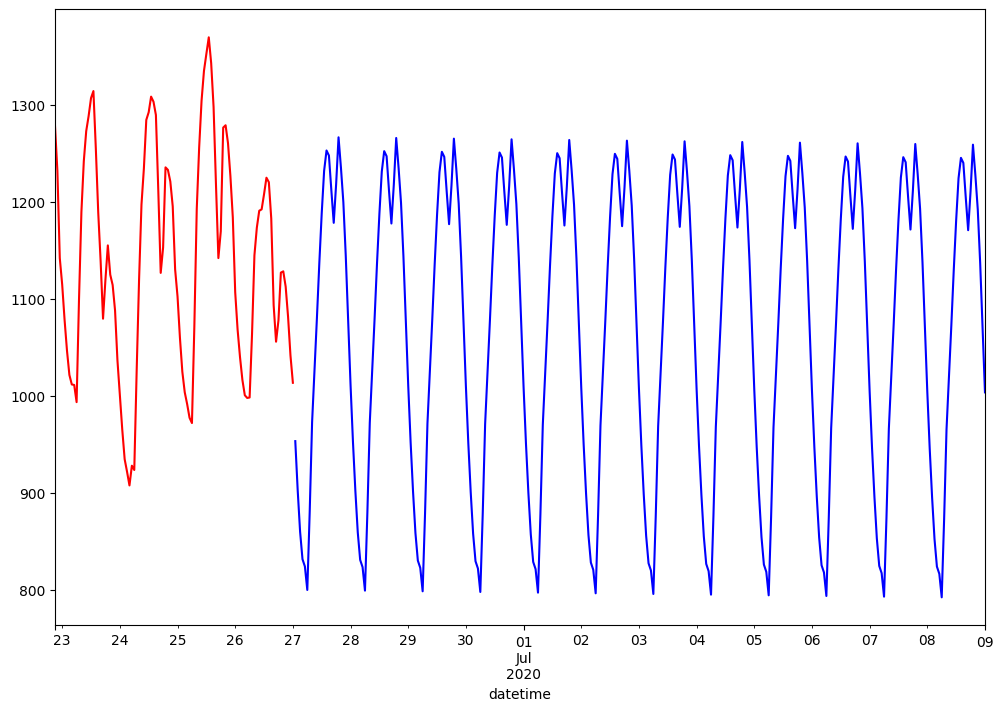

In [67]:
# Setting the number of days for the forecast
day_forecast = 12
hours_forecast = day_forecast * 24

# Generating forecast predictions
forecast_predictions = final_model.forecast(hours_forecast)

# Plotting the last 100 data points in red and the forecast in blue
df['nat_demand'][-100:].plot(figsize=(12, 8), color='red')
forecast_predictions.plot(color='blue')

In [68]:
# Importing the Autoregression model from statsmodels library
from statsmodels.tsa.ar_model import AutoReg,ARResults

In [69]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [70]:
model = AutoReg(train_data['nat_demand'], lags=1)

In [71]:
ARfit = model.fit()

In [72]:
ARfit.params

const            58.992938
nat_demand.L1     0.949551
dtype: float64

In [73]:
# This is the general format for obtaining predictions
start=len(train_data['nat_demand'])
end=len(train_data['nat_demand'])+len(test_data['nat_demand'])-1
predictions1 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

<Axes: xlabel='datetime'>

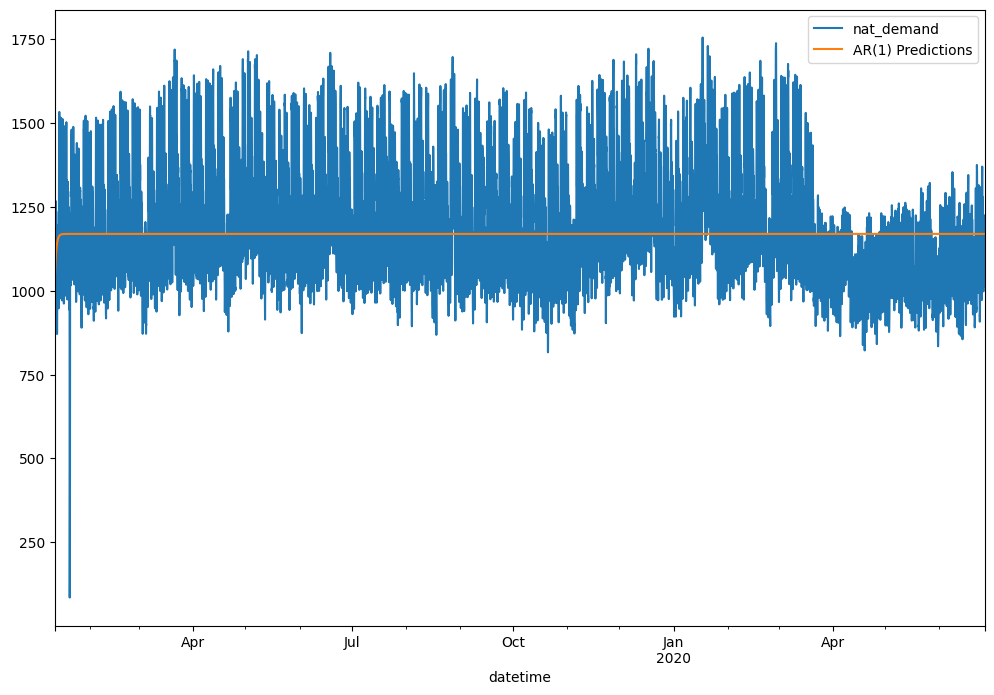

In [74]:
test_data['nat_demand'].plot(figsize=(12, 8), legend=True)
predictions1.plot(figsize=(12, 8), legend=True)

In [77]:
mae = mean_absolute_error(test_data['nat_demand'], predictions1)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(test_data['nat_demand'], predictions1)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 157.54172549567684
Mean Squared Error: 38004.931147259405
Root Mean Squared Error: 194.9485346117262


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


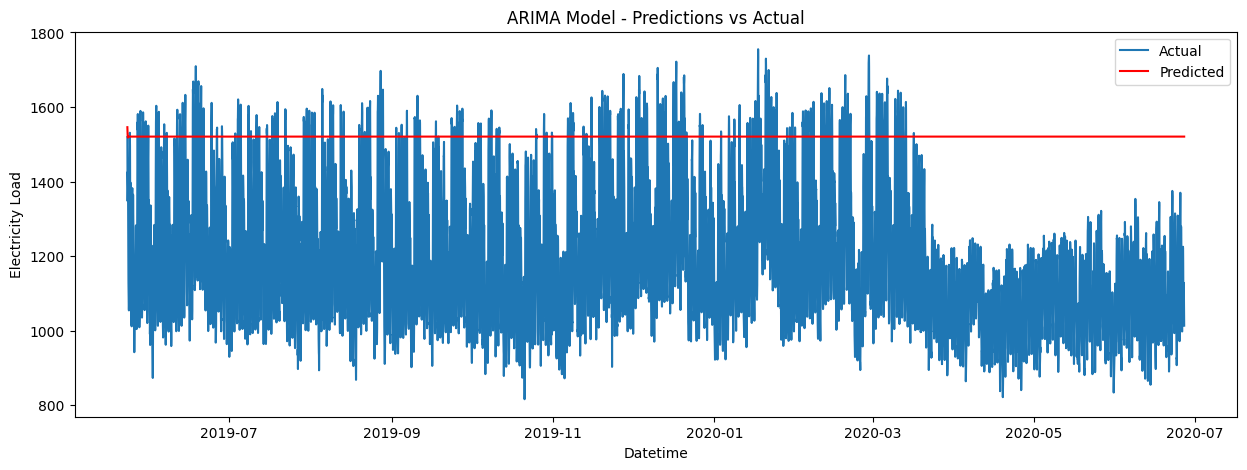

In [33]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

# Example with ARIMA
from statsmodels.tsa.arima.model import ARIMA

# Fit the model
model = ARIMA(train_data['nat_demand'], order=(5, 1, 0))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test_data))

# Plot predictions vs actual values
plt.figure(figsize=(15, 5))
plt.plot(test_data.index, test_data['nat_demand'], label='Actual')
plt.plot(test_data.index, predictions, label='Predicted', color='red')
plt.title('ARIMA Model - Predictions vs Actual')
plt.xlabel('Datetime')
plt.ylabel('Electricity Load')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(test_data['nat_demand'], predictions, squared=False)
mae = mean_absolute_error(test_data['nat_demand'], predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


RMSE: 360.375952364355
MAE: 318.1398013248337


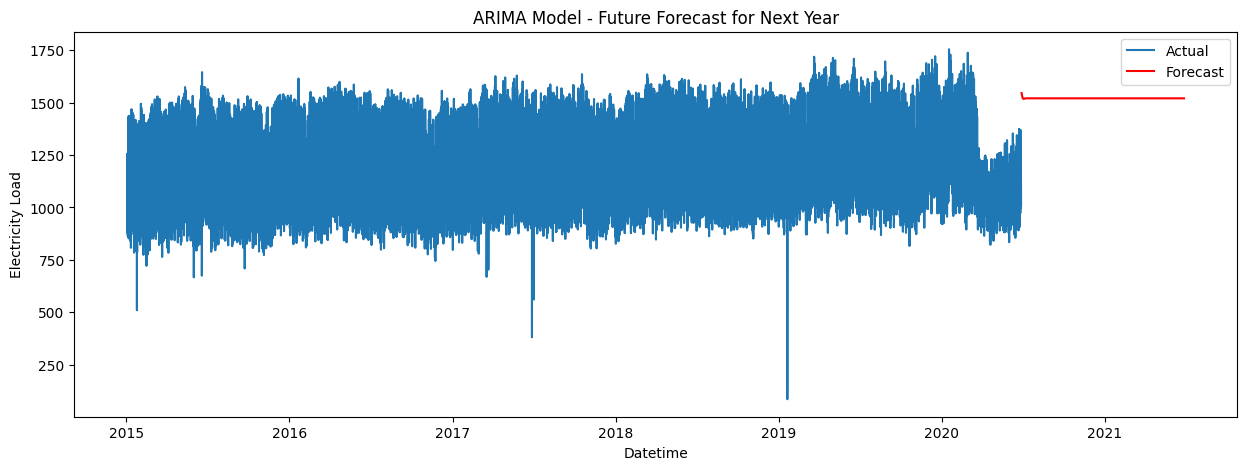

In [38]:
# Forecast future values for the next year (365 days)
future_predictions = model_fit.forecast(steps=365)

# Generate a date range for the next year, starting from the day after the last data point in the original DataFrame
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')

plt.figure(figsize=(15, 5))
plt.plot(df.index, df['nat_demand'], label='Actual')
plt.plot(future_dates, future_predictions, label='Forecast', color='red')
plt.title('ARIMA Model - Future Forecast for Next Year')
plt.xlabel('Datetime')
plt.ylabel('Electricity Load')
plt.legend()
plt.show()


In [82]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define and fit the SARIMA model
sarima_model = SARIMAX(train_data['nat_demand'],
                       order=(5, 1, 0),
                       seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit()

# Display the model summary
print(sarima_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           nat_demand   No. Observations:                35280
Model:             SARIMAX(5, 1, 0)x(1, 1, [1], 12)   Log Likelihood             -170863.423
Date:                              Tue, 06 Aug 2024   AIC                         341742.847
Time:                                      14:17:51   BIC                         341810.612
Sample:                                  01-03-2015   HQIC                        341764.424
                                       - 01-12-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3581      0.001    379.933      0.000       0.356       0.360
ar.L2         -0.00

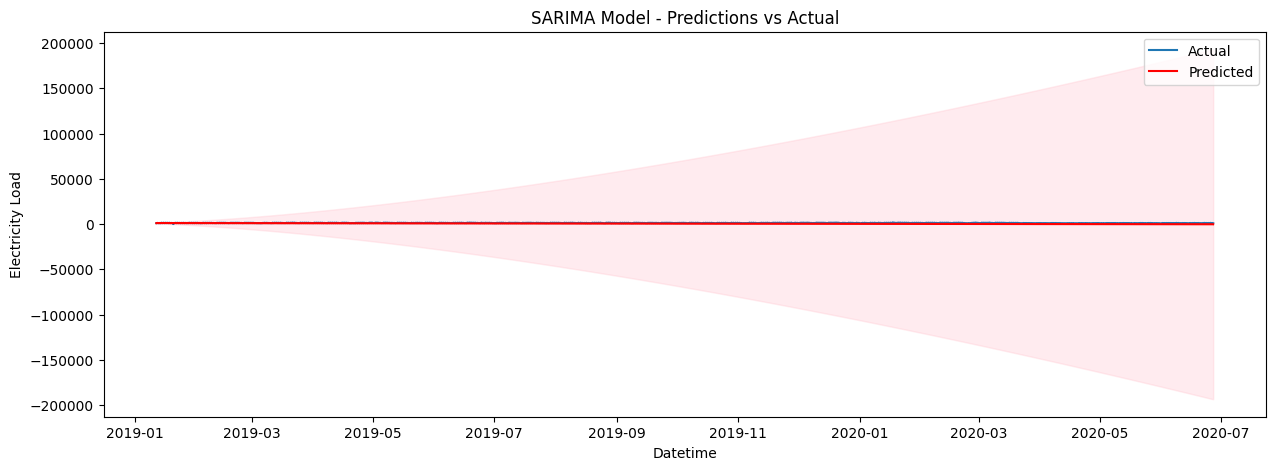

In [83]:
# Make predictions
sarima_predictions = sarima_model_fit.get_forecast(steps=len(test_data))
predicted_mean = sarima_predictions.predicted_mean
confidence_intervals = sarima_predictions.conf_int()

# Plot predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(test_data.index, test_data['nat_demand'], label='Actual')
plt.plot(test_data.index, predicted_mean, label='Predicted', color='red')
plt.fill_between(test_data.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Model - Predictions vs Actual')
plt.xlabel('Datetime')
plt.ylabel('Electricity Load')
plt.legend()
plt.show()


In [84]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE and MAE
rmse = mean_squared_error(test_data['nat_demand'], predicted_mean, squared=False)
mae = mean_absolute_error(test_data['nat_demand'], predicted_mean)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 810.8987106660445
MAE: 717.5487675224448


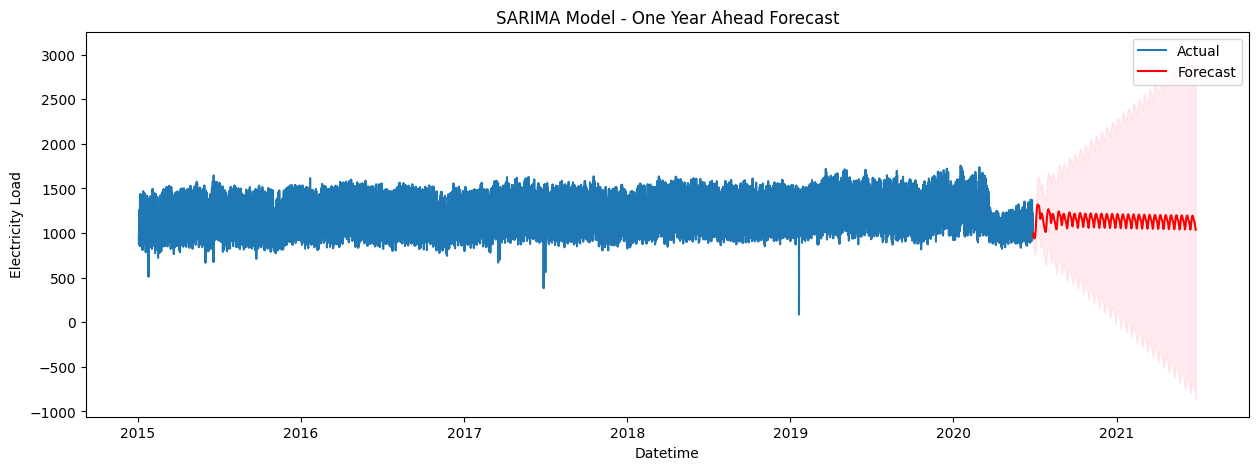

In [86]:
# Forecast future values (next 365 days)
future_steps = 365
sarima_forecast = sarima_model_fit.get_forecast(steps=future_steps)
forecast_mean = sarima_forecast.predicted_mean
forecast_conf_int = sarima_forecast.conf_int()

# Plot the forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df.index, df['nat_demand'], label='Actual')
plt.plot(pd.date_range(start=df.index[-1], periods=future_steps+1, freq='D')[1:], forecast_mean, label='Forecast', color='red')
plt.fill_between(pd.date_range(start=df.index[-1], periods=future_steps+1, freq='D')[1:],
                 forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Model - One Year Ahead Forecast')
plt.xlabel('Datetime')
plt.ylabel('Electricity Load')
plt.legend()
plt.show()
